# Content Based Model 
Testing a content-based recommendation system on a dataset of 12k+ books. The main question in this experiment:

"Will a recommendation based on descriptions provide better results than the details laten in a collaborative filtering 
system?"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy 
import squarify
from collections import Counter
nlp = spacy.load("en_core_web_lg")

In [5]:
books = pd.read_csv('https://zernach.com/wp-content/uploads/2020/04/filtered35k.csv')
books.head()

,id,title,authors,publisher,publishedDate,description,isbn,pageCount,categories,thumbnail,smallThumbnail,language,webReaderLink,textSnippet,isEbook,averageRating,maturityRating,ratingsCount,subtitle,index
0,MkHJ91AwS8MC,A Long Way Gone,Ishmael Beah,Macmillan,2007-02-13,"In a heart-wrenching, candid autobiography, a ...",9780374105235,229.0,Biography & Autobiography,http://books.google.com/books/content?id=MkHJ9...,http://books.google.com/books/content?id=MkHJ9...,en,http://play.google.com/books/reader?id=MkHJ91A...,NaN,0.0,4.0,NOT_MATURE,206.0,Memoirs of a Boy Soldier,NaN
1,MyaZDwAAQBAJ,The Better Half,"Dr. Sharon Moalem, MD, PhD","Farrar, Straus and Giroux",2020-04-07,An award-winning physician and scientist makes...,1250174791,288.0,Science,http://books.google.com/books/content?id=MyaZD...,http://books.google.com/books/content?id=MyaZD...,en,http://play.google.com/books/reader?id=MyaZDwA...,NaN,1.0,NaN,NOT_MATURE,NaN,On the Genetic Superiority of Women,NaN
2,0h-ZDwAAQBAJ,The Dominant Animal,Kathryn Scanlan,MCD x FSG Originals,2020-04-07,A collection of innovative and ambitious short...,0374719985,160.0,Fiction,http://books.google.com/books/content?id=0h-ZD...,http://books.google.com/books/content?id=0h-ZD...,en,http://play.google.com/books/reader?id=0h-ZDwA...,NaN,1.0,NaN,NOT_MATURE,NaN,Stories,NaN
3,GZyEDwAAQBAJ,When It Was Grand,LeeAnna Keith,Hill and Wang,2020-01-14,A group biography of the activists who defende...,1429947586,352.0,History,http://books.google.com/books/content?id=GZyED...,http://books.google.com/books/content?id=GZyED...,en,http://play.google.com/books/reader?id=GZyEDwA...,NaN,1.0,NaN,NOT_MATURE,NaN,The Radical Republican History of the Civil War,NaN
4,7mklDwAAQBAJ,New Collected Poems,Marianne Moore,NaN,2017-06-20,"""The definitive collected edition of one of ou...",0374221049,480.0,Poetry,http://books.google.com/books/content?id=7mklD...,http://books.google.com/books/content?id=7mklD...,en,http://play.google.com/books/reader?id=7mklDwA...,NaN,0.0,NaN,NOT_MATURE,NaN,NaN,NaN


In [6]:
i = 0
print(books['title'].iloc[i])
print(books['smallThumbnail'].iloc[i])
books['description'].iloc[i]

A Long Way Gone
http://books.google.com/books/content?id=MkHJ91AwS8MC&printsec=frontcover&img=1&zoom=5&edge=curl&source=gbs_api


'In a heart-wrenching, candid autobiography, a human rights activist offers a firsthand account of war from the perspective of a former child soldier, detailing the violent civil war that wracked his native Sierra Leone and the government forces that transformed a gentle young boy into a killer as a member of the army. 75,000 first printing.'

In [3]:
books['ratingsCount'].isnull().sum()

8989

In [21]:
desc = books['description'].str.lower()
desc.head()

0    in a heart-wrenching, candid autobiography, a ...
1    an award-winning physician and scientist makes...
2    a collection of innovative and ambitious short...
3    a group biography of the activists who defende...
4    "the definitive collected edition of one of ou...
Name: description, dtype: object

In [38]:
# Visualize all words to decide whether or not to extend stop-words
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

def get_simple_tokens(corpus, ext_stop=False, sw=None):
    tokens = []

    for doc in tokenizer.pipe(desc, batch_size=500):
        doc_tokens = []
        for token in doc:
            if ext_stop:
                if token.text not in sw:
                    doc_tokens.append(token.text)
            else:
                if (token.is_stop == False) & (token.is_punct == False):
                    doc_tokens.append(token.text)
        tokens.append(doc_tokens)
        
    return tokens

In [3]:
# Helpful counting function
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

The plot is such that it seems necessary to remove the following words:
- new 
- book
- author
- story
- life
- work
- best

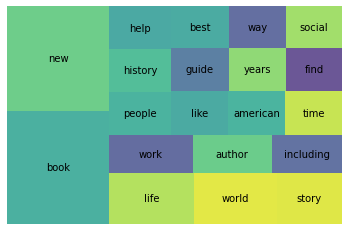

In [32]:
# Visualize with squarify plot
wc = count(tokens)
top_20 = wc[wc["rank"] <= 20]

squarify.plot(sizes=top_20["pct_total"], label=top_20["word"], alpha=0.8)
plt.axis("off")
plt.show()

In [40]:
# Extend stop words
stop_words = nlp.Defaults.stop_words.union(["new", "book", "author"
                                            "story", "life", "work", "best"])

tokens = get_simple_tokens(desc, ext_stop=True, sw=stop_words)

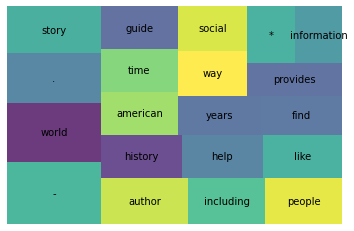

In [41]:
# Revisit visualization
wc = count(tokens)
top_20 = wc[wc["rank"] <= 20]

squarify.plot(sizes=top_20["pct_total"], label=top_20["word"], alpha=0.8)
plt.axis("off")
plt.show()

A few things to do in this notebook:
- Find a good way to get as much meaning from the description as possible
- Create some sort of vector, tfidf may not work that well here, needs to be seen
- Try the recommendation system from the notebook, and try nearest neighbors